In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
import zipfile
import os

#압축 파일 경로
zip_path = "/content/drive/MyDrive/프로젝트/datafinal.zip"
#압축 해제 경로
extract_path = "/content/drive/MyDrive/프로젝트/DataFinal"

#압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print("압축 해제 완료!")

#압축 해제된 파일 목록 확인
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))
'''

'\nimport zipfile\nimport os\n\n#압축 파일 경로\nzip_path = "/content/drive/MyDrive/프로젝트/datafinal.zip"\n#압축 해제 경로\nextract_path = "/content/drive/MyDrive/프로젝트/DataFinal"\n\n#압축 해제\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n    print("압축 해제 완료!")\n\n#압축 해제된 파일 목록 확인\nfor root, dirs, files in os.walk(extract_path):\n    for file in files:\n        print(os.path.join(root, file))\n'

In [ ]:
import random
import numpy as np
import os

import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import cv2

# ✅ 시드 설정 함수 (멀티 GPU 및 재현성 강화 포함)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

CFG = {
    'SEED': 42,
    'BATCH_SIZE': 4,
    'EPOCHS': 50,
    'LR': 0.0001
}

seed_everything(CFG['SEED'])

In [ ]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
# 커스텀 데이터셋 정의
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_files = sorted(os.listdir(gray_dir))
        self.color_files = sorted(os.listdir(color_dir))
        self.transform = transform

    def __len__(self):
        return len(self.gray_files)

    def __getitem__(self, idx):
        gray_img_path = os.path.join(self.gray_dir, self.gray_files[idx])
        color_img_path = os.path.join(self.color_dir, self.color_files[idx])

        try:
            gray_img = Image.open(gray_img_path).convert("L")
            color_img = Image.open(color_img_path).convert("RGB")
        except Exception as e:
            print(f"이미지를 열 수 없습니다: {gray_img_path}, {color_img_path}, 오류: {e}")
            # 대체 이미지로 넘어가기 (끝까지 돌아감)
            return self.__getitem__((idx + 1) % len(self.gray_files))

        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)

        return {'A': gray_img, 'B': color_img}

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=True, path='checkpoint.pt'):

        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # loss가 낮을수록 좋기 때문에 부호 반전

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping 카운터: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                print("🛑 Early stopping")
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        ''' 모델 저장 '''
        if self.verbose:
            print(f"✅ 검증 손실 개선됨. 모델 저장: {self.path}")
        torch.save(model.state_dict(), self.path)

In [ ]:
import torchvision.transforms as transforms

# ✅ 전처리 정의
gray_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ 데이터 경로 설정
gray_dir = '/content/drive/MyDrive/프로젝트/DataFinal/gray'
color_dir = '/content/drive/MyDrive/프로젝트/DataFinal/color'
test_dir = '/content/drive/MyDrive/프로젝트/DataFinal/test'

val_gray_dir = '/content/drive/MyDrive/프로젝트/DataFinal/validation/val_gray'
val_color_dir = '/content/drive/MyDrive/프로젝트/DataFinal/validation/val_color'


# ✅ 데이터 로더 정의
dataset = CustomDataset(gray_dir=gray_dir, color_dir=color_dir, transform=gray_transform)
dataloader = DataLoader(dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=1)

val_dataset = CustomDataset(gray_dir=val_gray_dir, color_dir=val_color_dir, transform=gray_transform)
val_dataloader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=1)

In [ ]:
# U-Net Generator 정의
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, kernel_size=4, stride=2, padding=1),
                      nn.BatchNorm2d(out_feat),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

# PatchGAN Discriminator 정의
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=4):  # 1(gray) + 3(color)
        super(PatchGANDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(in_channels, 64, normalization=False),
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

dataloader = DataLoader(
    dataset,
    batch_size=CFG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0,
    worker_init_fn=seed_worker,
    generator=g
)

In [ ]:
# 테스트 이미지 전처리 함수
def load_image(image_path, transform):
    image = Image.open(image_path).convert("L")
    image = transform(image).unsqueeze(0)
    return image
print("Saved all images")

Saved all images


In [ ]:
# 가중치 초기화 함수
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# 모델 초기화 및 설정
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=CFG['LR'])
optimizer_D = optim.Adam(discriminator.parameters(), lr=CFG['LR'])

In [ ]:
# VGG
class VGGFeatureExtractor(nn.Module):
    def __init__(self, layers=('relu5_1',)):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layer_name_mapping = {
            'relu1_1': 1, 'relu1_2': 3,
            'relu2_1': 6, 'relu2_2': 8,
            'relu3_1': 11, 'relu3_2': 13, 'relu3_3': 15, 'relu3_4': 17,
            'relu4_1': 20, 'relu4_2': 22, 'relu4_3': 24, 'relu4_4': 26,
            'relu5_1': 29, 'relu5_2': 31, 'relu5_3': 33, 'relu5_4': 35,
        }
        max_layer = max([self.layer_name_mapping[layer] for layer in layers])
        self.slice = nn.Sequential()
        for x in range(max_layer + 1):
            self.slice.add_module(str(x), vgg[x])
        for param in self.slice.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.slice(x)

# VGG 정규화 함수
def normalize_for_vgg(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    return (x - mean) / std

# 설정
torch.backends.cudnn.benchmark = False
best_loss = float("inf")
model_save_dir = "./saved_models"
os.makedirs(model_save_dir, exist_ok=True)

lambda_pixel = 50
lambda_perceptual = 15

# Early Stopping 설정
patience = 10  # 개선 없으면 멈출 에폭 수
early_stop_counter = 0

# VGG 추출기와 perceptual loss 설정
vgg_extractor = VGGFeatureExtractor(layers=('relu5_1',)).to(device)
criterion_perceptual = nn.MSELoss()

# 기록용 리스트
train_G_losses = []
train_D_losses = []
val_G_losses = []

train_D_accs = []
val_D_accs = []

for epoch in range(1, CFG['EPOCHS'] + 1):
    generator.train()
    discriminator.train()
    total_G_loss = 0.0
    total_D_loss = 0.0
    correct_D = 0
    total_D = 0

    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # === Generator ===
        optimizer_G.zero_grad()
        fake_B = generator(real_A)

        pred_fake = discriminator(real_A, fake_B)
        loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake).to(device))
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        fake_vgg_input = normalize_for_vgg((fake_B + 1) / 2)
        real_vgg_input = normalize_for_vgg((real_B + 1) / 2)
        vgg_fake = vgg_extractor(fake_vgg_input)
        vgg_real = vgg_extractor(real_vgg_input)
        loss_perceptual = criterion_perceptual(vgg_fake, vgg_real)

        loss_G = loss_GAN + lambda_pixel * loss_pixel + lambda_perceptual * loss_perceptual
        loss_G.backward()
        optimizer_G.step()

        # === Discriminator ===
        optimizer_D.zero_grad()
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real).to(device))

        pred_fake = discriminator(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake).to(device))

        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()

        # === Loss Accumulate ===
        total_G_loss += loss_G.item()
        total_D_loss += loss_D.item()

        # === Accuracy 계산 ===
        correct_D += (pred_real > 0.5).float().eq(1).sum().item()
        correct_D += (pred_fake < 0.5).float().eq(1).sum().item()
        total_D += pred_real.numel() + pred_fake.numel()

        print(f"[Epoch {epoch}/{CFG['EPOCHS']}] [Batch {i}/{len(dataloader)}] "
              f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

    avg_G_loss = total_G_loss / len(dataloader)
    avg_D_loss = total_D_loss / len(dataloader)
    train_G_losses.append(avg_G_loss)
    train_D_losses.append(avg_D_loss)
    train_D_accs.append(correct_D / total_D)

    # === Validation ===
    generator.eval()
    total_val_G_loss = 0.0
    correct_val_D = 0
    total_val_D = 0

    with torch.no_grad():
        for batch in val_dataloader:
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            fake_B = generator(real_A)

            fake_vgg_input = normalize_for_vgg((fake_B + 1) / 2)
            real_vgg_input = normalize_for_vgg((real_B + 1) / 2)
            vgg_fake = vgg_extractor(fake_vgg_input)
            vgg_real = vgg_extractor(real_vgg_input)
            loss_perceptual = criterion_perceptual(vgg_fake, vgg_real)
            loss_pixel = criterion_pixelwise(fake_B, real_B)

            loss_val_G = lambda_pixel * loss_pixel + lambda_perceptual * loss_perceptual
            total_val_G_loss += loss_val_G.item()

            # Accuracy 계산
            pred_real = discriminator(real_A, real_B)
            pred_fake = discriminator(real_A, fake_B)

            correct_val_D += (pred_real > 0.5).float().eq(1).sum().item()
            correct_val_D += (pred_fake < 0.5).float().eq(1).sum().item()
            total_val_D += pred_real.numel() + pred_fake.numel()

    avg_val_G_loss = total_val_G_loss / len(val_dataloader)
    val_G_losses.append(avg_val_G_loss)
    val_D_accs.append(correct_val_D / total_val_D)

    print(f"Epoch {epoch} Summary: "
          f"Train G Loss: {avg_G_loss:.4f}, "
          f"Train D Loss: {avg_D_loss:.4f}, "
          f"Train D Acc: {train_D_accs[-1]:.4f}, "
          f"Val G Loss: {avg_val_G_loss:.4f}, "
          f"Val D Acc: {val_D_accs[-1]:.4f}")

    # === Best Model 저장 (validation loss 기준) ===
    if avg_val_G_loss < best_loss:
        best_loss = avg_val_G_loss
        early_stop_counter = 0  # 개선되었으므로 초기화
        torch.save(generator.state_dict(), os.path.join(model_save_dir, "best_generator.pth"))
        torch.save(discriminator.state_dict(), os.path.join(model_save_dir, "best_discriminator.pth"))
        print(f"✅ Best model saved at epoch {epoch}")
    else:
        early_stop_counter += 1
        print(f"⏸️ No improvement in val_loss for {early_stop_counter} epoch(s).")

    # === Early Stopping 조건 확인 ===
    if early_stop_counter >= patience:
        print(f"⛔ Early stopping triggered at epoch {epoch}. Best val_loss: {best_loss:.4f}")
        break

    generator.train()

'''
# 학습 루프
for epoch in range(1, CFG['EPOCHS'] + 1):
    total_G_loss = 0.0
    total_D_loss = 0.0

    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)  # input
        real_B = batch['B'].to(device)  # target

        optimizer_G.zero_grad()

        fake_B = generator(real_A)

        pred_fake = discriminator(real_A, fake_B)
        loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # perceptual loss: [-1,1] → [0,1] → VGG 정규화
        fake_vgg_input = normalize_for_vgg((fake_B + 1) / 2)
        real_vgg_input = normalize_for_vgg((real_B + 1) / 2)
        vgg_fake = vgg_extractor(fake_vgg_input)
        vgg_real = vgg_extractor(real_vgg_input)
        loss_perceptual = criterion_perceptual(vgg_fake, vgg_real)

        # total generator loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel + lambda_perceptual * loss_perceptual
        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        pred_fake = discriminator(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()

        total_G_loss += loss_G.item()
        total_D_loss += loss_D.item()

        # 로그 및 모델 저장
        print(f"[Epoch {epoch}/{CFG['EPOCHS']}] [Batch {i}/{len(dataloader)}] "
              f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

        if loss_G.item() < best_loss:
            best_loss = loss_G.item()
            torch.save(generator.state_dict(), os.path.join(model_save_dir, "best_generator.pth"))
            torch.save(discriminator.state_dict(), os.path.join(model_save_dir, "best_discriminator.pth"))
            print(f"Best model saved at epoch {epoch}, batch {i}")


    avg_G_loss = total_G_loss / len(dataloader)
    avg_D_loss = total_D_loss / len(dataloader)
    train_G_losses.append(avg_G_loss)
    train_D_losses.append(avg_D_loss)

'''

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 82.6MB/s]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Epoch 30/50] [Batch 283/375] [D loss: 0.1775] [G loss: 6.2090]
[Epoch 30/50] [Batch 284/375] [D loss: 0.2050] [G loss: 6.2121]
[Epoch 30/50] [Batch 285/375] [D loss: 0.1410] [G loss: 5.9908]
[Epoch 30/50] [Batch 286/375] [D loss: 0.0988] [G loss: 7.4268]
[Epoch 30/50] [Batch 287/375] [D loss: 0.1288] [G loss: 8.0135]
[Epoch 30/50] [Batch 288/375] [D loss: 0.1487] [G loss: 6.1601]
[Epoch 30/50] [Batch 289/375] [D loss: 0.0803] [G loss: 6.5372]
[Epoch 30/50] [Batch 290/375] [D loss: 0.0426] [G loss: 6.5686]
[Epoch 30/50] [Batch 291/375] [D loss: 0.0472] [G loss: 6.8505]
[Epoch 30/50] [Batch 292/375] [D loss: 0.1487] [G loss: 6.8284]
[Epoch 30/50] [Batch 293/375] [D loss: 0.0814] [G loss: 7.0815]
[Epoch 30/50] [Batch 294/375] [D loss: 0.0452] [G loss: 6.0573]
[Epoch 30/50] [Batch 295/375] [D loss: 0.0952] [G loss: 6.6897]
[Epoch 30/50] [Batch 296/375] [D loss: 0.1682] [G loss: 5.4796]
[Epoch 30/50] [Batch 297/375] [D loss: 0.3180] [G loss: 5.9344]
[Epo

KeyboardInterrupt: 

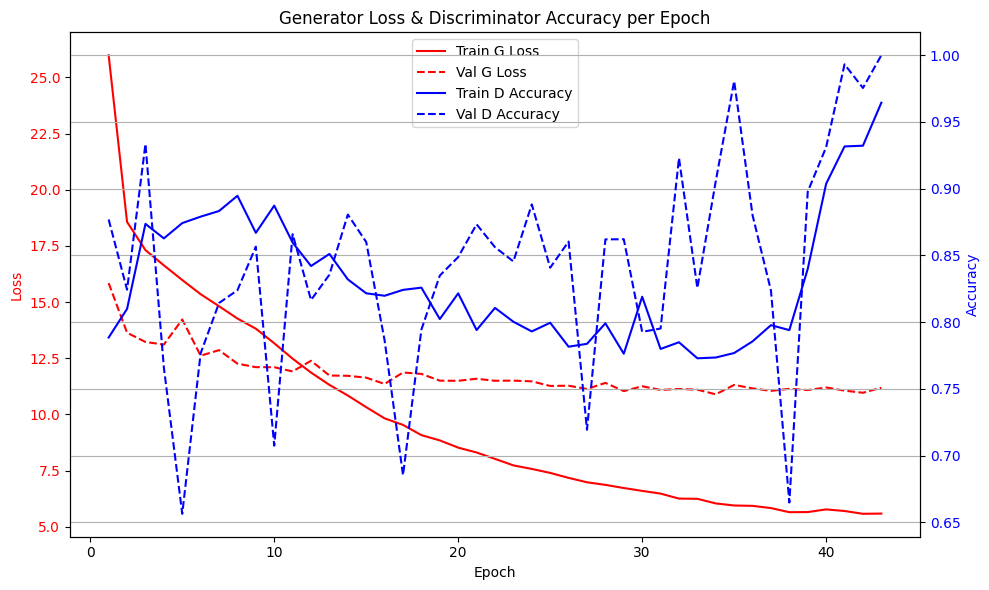

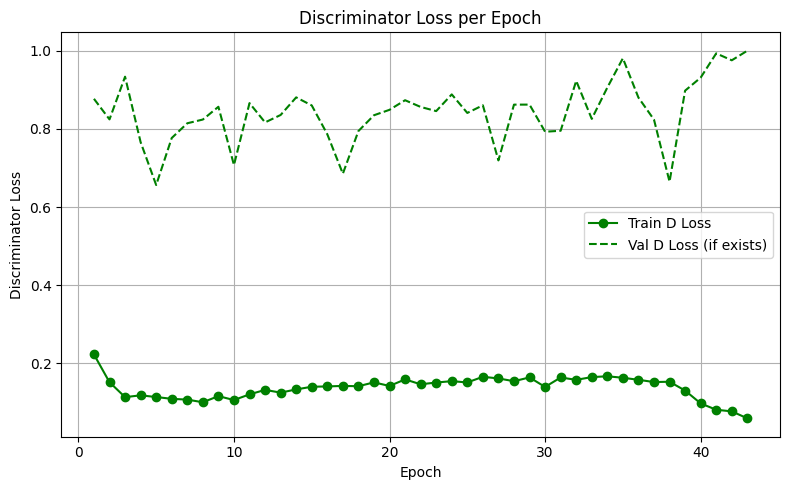

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_G_losses) + 1)

# 1. 기존 그래프 (Generator Loss + Accuracy)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(epochs, train_G_losses, 'r-', label='Train G Loss')
ax1.plot(epochs, val_G_losses, 'r--', label='Val G Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(epochs, train_D_accs, 'b-', label='Train D Accuracy')
ax2.plot(epochs, val_D_accs, 'b--', label='Val D Accuracy')
ax2.set_ylabel('Accuracy', color='b')
ax2.tick_params(axis='y', labelcolor='b')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')
plt.title("Generator Loss & Discriminator Accuracy per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 별도의 그래프 (Discriminator Loss)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_D_losses, 'g-o', label='Train D Loss')
plt.plot(epochs, val_D_accs, 'g--', label='Val D Loss (if exists)')
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 테스트 및 결과 저장
submission_dir = "/content/drive/MyDrive/프로젝트/최종_3"
os.makedirs(submission_dir, exist_ok=True)

test_images = sorted(os.listdir(test_dir))

# Generator 모델 불러오기
generator.load_state_dict(torch.load(os.path.join(model_save_dir, "best_generator.pth")))
generator.eval()

for image_name in test_images:
    test_image_path = os.path.join(test_dir, image_name)
    test_image = load_image(test_image_path, gray_transform).to(device)

    with torch.no_grad():
        pred_image = generator(test_image)
        pred_image = pred_image.cpu().squeeze(0)
        pred_image = pred_image * 0.5 + 0.5
        pred_image = pred_image.numpy().transpose(1, 2, 0)
        pred_image = (pred_image * 255).astype('uint8')
        pred_image_resized = cv2.resize(pred_image, (512, 512), interpolation=cv2.INTER_LINEAR)

    output_path = os.path.join(submission_dir, image_name)
    cv2.imwrite(output_path, cv2.cvtColor(pred_image_resized, cv2.COLOR_RGB2BGR))

print("✅ 테스트 결과 저장 완료!")

✅ 테스트 결과 저장 완료!


In [ ]:
!pip install lpips
!pip install torch_fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 94.9MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


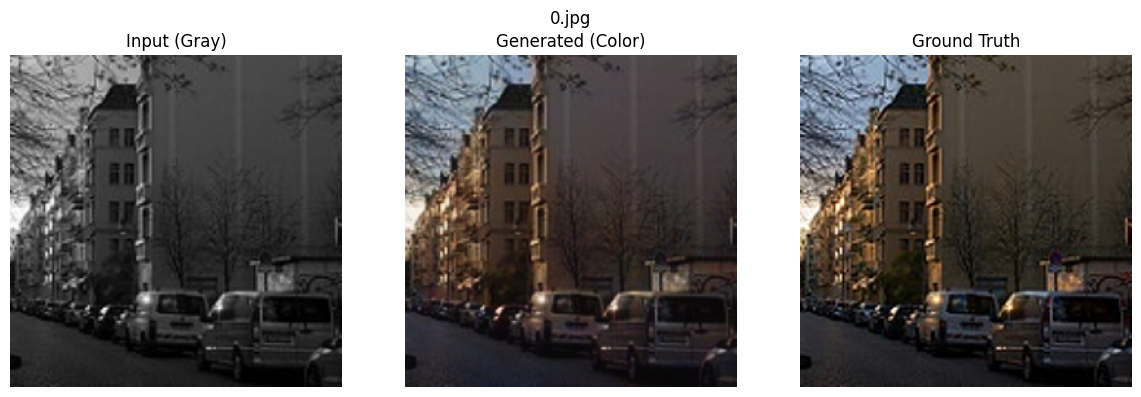

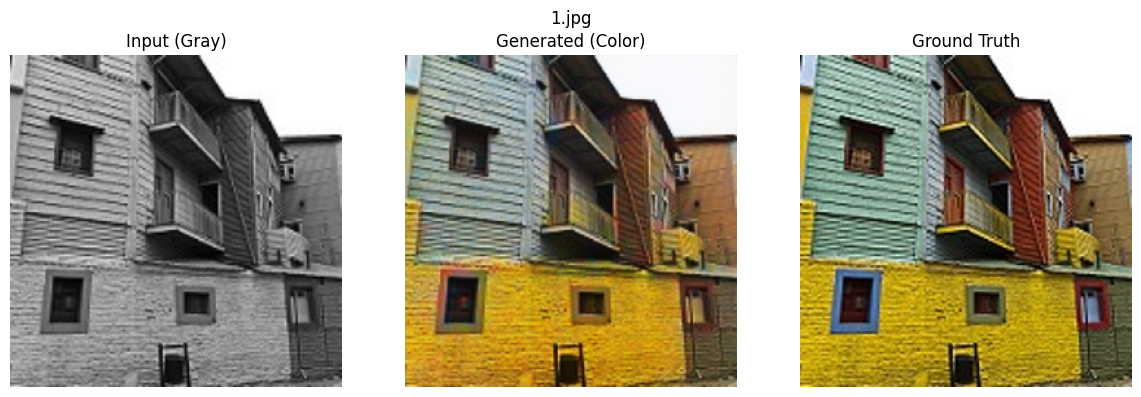

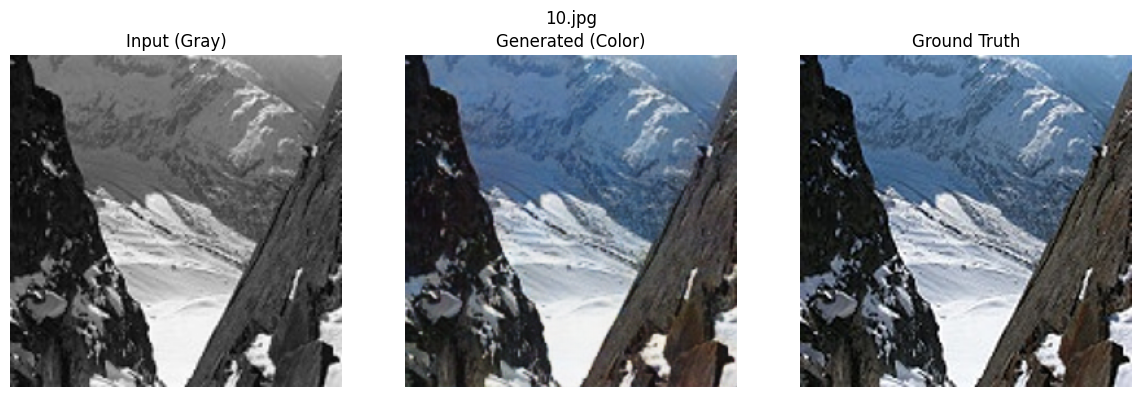

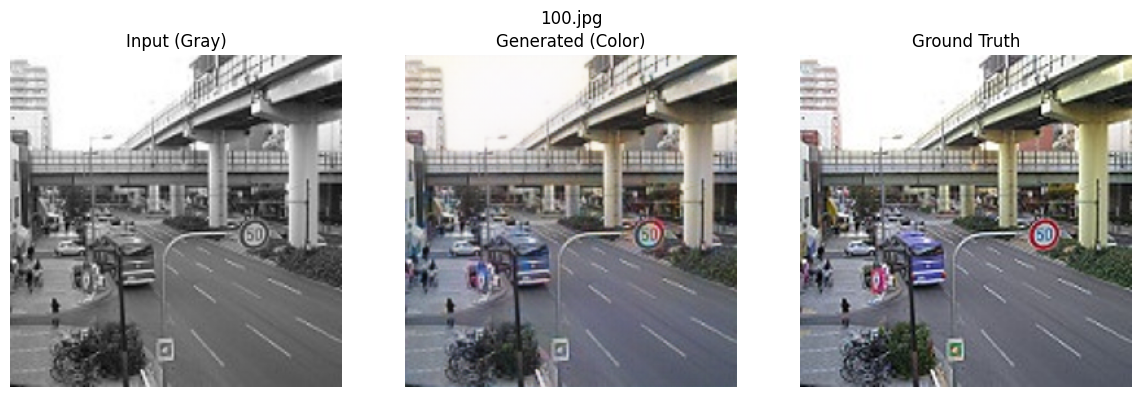


✅ 평균 PSNR: 29.25
✅ 평균 SSIM: 0.9334
✅ 평균 LPIPS: 0.0609


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 232MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "./eval/fake" with extensions png,jpg,jpeg
Found 150 samples, some are lossy-compressed - this may affect metrics
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-pac

✅ FID: 33.57


Frechet Inception Distance: 33.56566232720439


In [ ]:
import lpips
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.metrics import structural_similarity as ssim_fn
from torch_fidelity import calculate_metrics
import shutil

# 평가용 폴더 생성
eval_fake_dir = './eval/fake'
eval_real_dir = './eval/real'
shutil.rmtree('./eval', ignore_errors=True)
os.makedirs(eval_fake_dir, exist_ok=True)
os.makedirs(eval_real_dir, exist_ok=True)

# 전처리
def preprocess(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
        image = image.resize((256, 256))
        return np.array(image).astype('float32') / 255.0
    except Exception as e:
        print(f"❌ GT 이미지 불러오기 실패: {img_path}, 오류: {e}")
        return None

# 이미지 시각화 함수
def visualize_images(input_tensor, generated_np, gt_np, title=""):
    # 입력은 1채널 그레이스케일 텐서 (1, 256, 256)
    input_np = input_tensor.cpu().squeeze(0).numpy() * 0.5 + 0.5
    input_np = np.clip(input_np, 0, 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_np, cmap='gray')
    plt.title("Input (Gray)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(generated_np)
    plt.title("Generated (Color)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt_np)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# LPIPS 모델 초기화
lpips_model = lpips.LPIPS(net='alex').to(device)

total_psnr = 0
total_ssim = 0
total_lpips = 0
count = 0

# 평가용 이미지 저장 및 지표 계산
for image_name in test_images:
    test_image_path = os.path.join(test_dir, image_name)
    color_image_path = os.path.join(color_dir, image_name)

    if not os.path.exists(test_image_path) or not os.path.exists(color_image_path):
        print(f"⚠️ 파일 누락: {image_name}, 생략")
        continue

    try:
        test_image = load_image(test_image_path, gray_transform).to(device)

        with torch.no_grad():
            pred_image = generator(test_image)
            pred_image = pred_image.cpu().squeeze(0)
            pred_image = pred_image * 0.5 + 0.5
            pred_image = np.clip(pred_image.numpy().transpose(1, 2, 0), 0, 1)

        gt_image = preprocess(color_image_path)
        if gt_image is None:
            continue

        # PSNR & SSIM
        psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=1.0)
        ssim = ssim_fn(gt_image, pred_image, data_range=1.0, win_size=7, channel_axis=-1)

        # LPIPS
        pred_tensor = torch.tensor(pred_image).permute(2, 0, 1).unsqueeze(0).to(device)
        gt_tensor = torch.tensor(gt_image).permute(2, 0, 1).unsqueeze(0).to(device)
        lpips_score = lpips_model(pred_tensor, gt_tensor).item()

        total_psnr += psnr
        total_ssim += ssim
        total_lpips += lpips_score
        count += 1

        # FID용 이미지 저장
        Image.fromarray((pred_image * 255).astype(np.uint8)).save(os.path.join(eval_fake_dir, image_name))
        Image.fromarray((gt_image * 255).astype(np.uint8)).save(os.path.join(eval_real_dir, image_name))

    except Exception as e:
        print(f"❌ 처리 중 오류 발생: {image_name}, 오류: {e}")
        continue

# 이미지 변환 과정 시각화
    if count < 5:
        visualize_images(test_image.squeeze(0), pred_image, gt_image, title=image_name)

if count == 0:
    print("❌ 유효한 평가 이미지가 없습니다. 경로 또는 파일명 확인 필요.")
else:
    print(f"\n✅ 평균 PSNR: {total_psnr / count:.2f}")
    print(f"✅ 평균 SSIM: {total_ssim / count:.4f}")
    print(f"✅ 평균 LPIPS: {total_lpips / count:.4f}")

    # FID 계산
    fid_result = calculate_metrics(
        input1=eval_fake_dir,
        input2=eval_real_dir,
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True,
        kid=False
    )
    print(f"✅ FID: {fid_result['frechet_inception_distance']:.2f}")

In [ ]:
from google.colab import files
files.download('/content/saved_models/best_generator.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>